In [1]:
cd ~/projects/halomassloss/core_catalog_mevolved

/data/a/cpac/isultan/projects/halomassloss/core_catalog_mevolved


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import subhalo_mass_loss_model_LJDS as SHMLM
import genericio as gio
from tqdm import tqdm
from itk import hist, h5_read_dict, gio_read_dict, loadpickle, plt_latex, periodic_bcs, many_to_one, h5_write_dict
from plot_subhalo_mass_fn import CMF, SHMF, plotCMF, plotSHMF
from cc_generate import vars_cc
from __future__ import division

In [150]:
PM = SHMLM.PARTICLES100MASS/100.

In [3]:
step = 499
z = SHMLM.step2z[step]
cc_old_evolved = h5_read_dict('/home/isultan/data/LastJourney/LJ_CoreCatalog_004_reduced/m000p-{}.coreproperties_complete.hdf5'.format(step), 'coredata')
cc_old_evolved['infall_mass'] = cc_old_evolved['infall_tree_node_mass']

In [4]:
satellites_mask = cc_old_evolved['central'] == 0
centrals_mask = cc_old_evolved['central'] == 1
# idx_m21 = many_to_one( cc_old_evolved['tree_node_index'][satellites_mask], cc_old_evolved['tree_node_index'][centrals_mask], verbose=True )
# h5_write_dict('/home/isultan/data/LastJourney/LJ_CoreCatalog_004_reduced/idx_m21.h5', {'idx_m21':idx_m21}, 'idxm21')

In [121]:
idx_m21 = h5_read_dict('/home/isultan/data/LastJourney/LJ_CoreCatalog_004_reduced/idx_m21_{}.h5'.format(step), 'idxm21')['idx_m21']

In [122]:
M = cc_old_evolved['infall_mass'][centrals_mask][idx_m21]

In [7]:
Coretag = cc_old_evolved['core_tag'][centrals_mask][idx_m21] 

In [8]:
Halominmass = cc_old_evolved['infall_mass'].min()

In [9]:
def hostbins(M1_th, M2_th, verbose=False, s1=False, Nhalos=10**4, minHalosFlag=False):
    massmask = (cc_old_evolved['infall_mass'][centrals_mask] >= M1_th)&(cc_old_evolved['infall_mass'][centrals_mask] < M2_th)
    asort = np.argsort(cc_old_evolved['infall_mass'][centrals_mask][massmask])
    if verbose:
        print 'Total host halos within mass threshold', np.sum(massmask)

    cim = cc_old_evolved['infall_mass'][centrals_mask][massmask][asort]
    ctni = cc_old_evolved['tree_node_index'][centrals_mask][massmask][asort]

    if minHalosFlag:
        Nhalos = np.sum(cim <= cim[Nhalos-1])
    if verbose:
        print 'Number of host halos in bin', np.format_float_scientific(Nhalos)
    
    bs_str = np.format_float_scientific(cim[Nhalos-1] - cim[0])
    if verbose:
        print "Host halo mass bin size:", bs_str
    M1, M2 = cim[0], cim[Nhalos-1]
    Mavg = np.mean(cim[:Nhalos])

    assert len(np.unique(ctni[:Nhalos]))==Nhalos
    isin = np.isin(cc_old_evolved['tree_node_index'][satellites_mask][(M1<=M)&(M<=M2)], ctni[:Nhalos]) 
    if s1:
        isin = isin&(Coretag[(M1<=M)&(M<=M2)]==cc_old_evolved['host_core'][satellites_mask][(M1<=M)&(M<=M2)])
    m_bin = cc_old_evolved['infall_mass'][satellites_mask][(M1<=M)&(M<=M2)][isin]
    Marray = M[(M1<=M)&(M<=M2)][isin]
    Nih = np.sum(isin)
    if verbose:
        print "Number of infall halos:", Nih

    ninfallhosts = len(np.unique(cc_old_evolved['tree_node_index'][satellites_mask][(M1<=M)&(M<=M2)][isin]))
    if verbose:
        print "Hosts with no infall halos: {} ({}%)".format(Nhalos-ninfallhosts, 100*(1-ninfallhosts/Nhalos))
        print ""
#     cnts, bedges = np.histogram( m_bin, bins=100 );
    title = 'Host halo mass bin size: {}\nNumber of infall halos: {} \nHosts with no infall halos: {} ({}%)\n$\langle M \\rangle=$ {}'.format(bs_str, Nih, Nhalos-ninfallhosts, 100*(1-ninfallhosts/Nhalos), np.format_float_scientific(Mavg))
    return m_bin, title, Marray, Mavg, Nhalos

In [ ]:
#mbin, title = hostbins(10**lM, verbose=True)

In [ ]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=[4.8*4,4.8*2], gridspec_kw={'hspace': .5}, dpi=100)
fig.suptitle('z={}'.format(z), y=1.01, fontsize=14)
for lM, ax in zip([12, 12.5, 13, 13.5, 14, 14.5], [ax1, ax2, ax3, ax4, ax5, ax6]):
    m_bin, title, _, _, _ = hostbins(10**lM, 10**(lM+0.5), verbose=True, s1=False)
    ax.hist(m_bin, bins=100)
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_ylabel('N')
    ax.set_xlabel('m')
    ax.set_title(title)
    ax.set_xlim(10**10, 10**14.5)

In [10]:
m_bin_all = []
for lM in [12.0, 12.5, 13.0, 13.5, 14.0, 14.5]:
    m_bin_all.append(hostbins(10**lM, 10**(lM+0.5), verbose=True, s1=False, minHalosFlag=True))

Total host halos within mass threshold 103359935
Number of host halos in bin 3.7842e+05
Host halo mass bin size: 1.31072e+05
Number of infall halos: 145318
Hosts with no infall halos: 240764 (63.6234871307%)

Total host halos within mass threshold 36298650
Number of host halos in bin 4.264e+04
Host halo mass bin size: 2.62144e+05
Number of infall halos: 89731
Hosts with no infall halos: 2389 (5.60272045028%)

Total host halos within mass threshold 12163595
Number of host halos in bin 1.4303e+04
Host halo mass bin size: 5.4347694e+09
Number of infall halos: 103913
Hosts with no infall halos: 0 (0.0%)

Total host halos within mass threshold 3662069
Number of host halos in bin 1.0102e+04
Host halo mass bin size: 5.435189e+10
Number of infall halos: 229534
Hosts with no infall halos: 0 (0.0%)

Total host halos within mass threshold 872353
Number of host halos in bin 1.0018e+04
Host halo mass bin size: 6.73924e+11
Number of infall halos: 701473
Hosts with no infall halos: 0 (0.0%)

Total ho

In [11]:
m_bin_all_s1 = []
for lM in [12.0, 12.5, 13.0, 13.5, 14.0, 14.5]:
    m_bin_all_s1.append(hostbins(10**lM, 10**(lM+0.5), verbose=True, s1=True, minHalosFlag=True))

Total host halos within mass threshold 103359935
Number of host halos in bin 3.7842e+05
Host halo mass bin size: 1.31072e+05
Number of infall halos: 145065
Hosts with no infall halos: 240764 (63.6234871307%)

Total host halos within mass threshold 36298650
Number of host halos in bin 4.264e+04
Host halo mass bin size: 2.62144e+05
Number of infall halos: 84390
Hosts with no infall halos: 2389 (5.60272045028%)

Total host halos within mass threshold 12163595
Number of host halos in bin 1.4303e+04
Host halo mass bin size: 5.4347694e+09
Number of infall halos: 83329
Hosts with no infall halos: 0 (0.0%)

Total host halos within mass threshold 3662069
Number of host halos in bin 1.0102e+04
Host halo mass bin size: 5.435189e+10
Number of infall halos: 149772
Hosts with no infall halos: 0 (0.0%)

Total host halos within mass threshold 872353
Number of host halos in bin 1.0018e+04
Host halo mass bin size: 6.73924e+11
Number of infall halos: 376732
Hosts with no infall halos: 0 (0.0%)

Total hos

In [146]:
for i in m_bin_all:
    M1 = i[2].min()
    M2 = i[2].max()
#     print np.log10(M1)
#     print np.log10(M2)
#     print np.format_float_scientific(M1)
#     print np.format_float_scientific(M2)
#     print round(M1/1e12, 3)
    print round(M2/1e12, 3)
#     print '<M>:', np.format_float_scientific(i[3])
#     print 'log <M>:', np.log10(i[3])
#     print 'host mass bin size:', np.format_float_scientific(M2-M1)
#     print 'host mass bin size (num particles):', int((M2-M1)/(SHMLM.PARTICLES100MASS/100.))
#     print ''

1.0
3.163
10.005
31.679
100.674
328.172


In [13]:
def unevolved_fitting_model(log_m_over_M, gamma1, alpha1, gamma2, alpha2, beta, zeta):
    psi = 10**log_m_over_M
    return  np.log10( 1./np.log10(np.e) * (gamma1*psi**alpha1 + gamma2*psi**alpha2) * np.exp(-beta*psi**zeta) )

In [14]:
def unevolved_fitting_fns(fitfn, r=None, valcnt=50, log_m_over_M=None):
    if log_m_over_M is None:
        l1, l2 = r
        log_m_over_M = np.linspace(l1, l2, valcnt)
    log_dN = None
    if fitfn == 'JB13':
        log_dN = unevolved_fitting_model(log_m_over_M, gamma1=0.13, alpha1=-0.83, gamma2=1.33, alpha2=-0.02, beta=5.67, zeta=1.19)
    elif fitfn == 'G08':
        log_dN = unevolved_fitting_model(log_m_over_M, gamma1=0.18, alpha1=-0.80, gamma2=0, alpha2=0, beta=12.27, zeta=3.00)
    elif fitfn == 'LM09':
        log_dN = unevolved_fitting_model(log_m_over_M, gamma1=0.2, alpha1=-0.76, gamma2=0, alpha2=0, beta=6.00, zeta=3.20)
    elif fitfn == 'LM09all':
        log_dN = unevolved_fitting_model(log_m_over_M, gamma1=0.22, alpha1=-0.91, gamma2=0, alpha2=0, beta=6.00, zeta=3.00)
    elif fitfn == 'fit':
        log_dN = unevolved_fitting_model(log_m_over_M, gamma1=1.10019253e-06, alpha1=-2.37629301e+00, gamma2=3.13151000e-01, alpha2=-6.62286828e-01, beta=1.62963600e+01, zeta=3.03449498e+00)
    return log_m_over_M, log_dN

In [15]:
plt.style.use(['science', 'high-vis'])

In [16]:
r = (-4,0.)
bins = 50
plotOptions = ''
alpha = 1

plotlist_all = []
for m_bin, title, Marray, Mavg, nH in m_bin_all:
    plotlist_all.append( plotCMF(None, M1=None, M2=None, s1=None, disrupt=None, returnUnevolved=None, r=r, plotOptions=plotOptions, bins=bins, alpha=alpha, plotFlag=False, parr=m_bin/Marray, nH=nH) )

plotlist_1 = []
for m_bin, title, Marray, Mavg, nH in m_bin_all_s1:
    plotlist_1.append( plotCMF(None, M1=None, M2=None, s1=None, disrupt=None, returnUnevolved=None, r=r, plotOptions=plotOptions, bins=bins, alpha=alpha, plotFlag=False, parr=m_bin/Marray, nH=nH) )

378420
42640
14303
10102
10018
10001
378420
42640
14303
10102
10018
10001


/home/isultan/projects/itk/itk.py:92: RuntimeWarning: divide by zero encountered in log10
  cnts = np.log10(cnts)


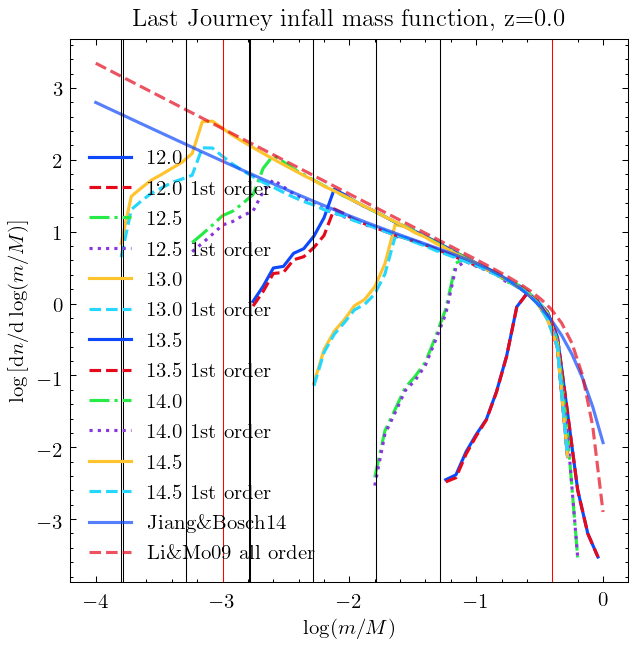

In [18]:
r = (-4,0.)
labels = ['12.0', '12.5', '13.0', '13.5', '14.0', '14.5']
colors = ['r', 'g', 'silver']

for i in range(6):
    x = plotlist_all[i][0]
    y = plotlist_all[i][1]
    plt.plot(x, y, label=labels[i])
    x = plotlist_1[i][0]
    y = plotlist_1[i][1]
    plt.plot(x, y, label=labels[i]+' 1st order')

xfit, yfit = unevolved_fitting_fns(r=r, fitfn='fit')
# plt.plot(xfit, yfit, label='fit', alpha=0.7)

xfit2, yfit2 = unevolved_fitting_fns(r=r, fitfn='JB13')
plt.plot(xfit2, yfit2, label='Jiang\&Bosch14', alpha=0.7)

xfit3, yfit3 = unevolved_fitting_fns(r=r, fitfn='G08')
# plt.plot(xfit3, yfit3, label='Giocoli+08', alpha=0.7)

xfit4, yfit4 = unevolved_fitting_fns(r=r, fitfn='LM09')
# plt.plot(xfit4, yfit4, label='Li\&Mo09', alpha=0.7)

xfit5, yfit5 = unevolved_fitting_fns(r=r, fitfn='LM09all')
plt.plot(xfit5, yfit5, label='Li\&Mo09 all order', alpha=0.7)

plt.xlabel(r'$\log(m/M)$')
plt.ylabel(r'$\log \left[ \mathrm{d}n/\mathrm{d} \log(m/M) \right]$')
plt.title( r'Last Journey infall mass function' + ', z=' + str(z) );
plt.legend()
# plt.ylim()
# plt.xlim(-.6,-.1)

for i in range(6):
#     plt.axvline(np.log10((SHMLM.PARTICLES100MASS/100.*20)/m_bin_all[i][2].max()), c='k', lw=.5)
#     plt.axvline(np.log10((SHMLM.PARTICLES100MASS/100.*20)/m_bin_all[i][2].min()), c='k', lw=.5)
    plt.axvline(np.log10(Halominmass/m_bin_all[i][2].max()), c='k', lw=.5)
    plt.axvline(np.log10(Halominmass/m_bin_all[i][2].min()), c='k', lw=.5)

plt.axvline(-3, c='r', lw=.5)
plt.axvline(-0.4, c='r', lw=.5)

1. For a given host halo mass bin containing $N_H=10^4$ host halos, create a histogram of $\log(m/M)$ using all halos that have merged into the $N_H$ merger trees (or only halos that have merged into the most massive progenitor branch when looking at first-order mass function).
2. For histogram bin $i$ with counts $N_i$, where bins are in $\log(m/M)$ with bin size $b$, error is $\delta_{N_i}$ = $\sqrt{N_i}$
3. Since we are plotting $y(N_i) = \log \left( N_i/(b*N_H) \right)$ where $N_H$ and $b$ are constants, error is $\delta_y = \pm [ y(N_i) - y(N_i \mp \delta_{N_i}) ]= \pm \log \frac{N_i}{N_i \mp \delta_{N_i}}$

In [20]:
r = (-3,-0.4)
bins = 40
plotOptions = ''
alpha = 1

plotlist_all_small = []
labels_Mavg_all_small = []
for m_bin, title, Marray, Mavg, nH in m_bin_all:
    plotlist_all_small.append( plotCMF(None, M1=None, M2=None, s1=None, disrupt=None, returnUnevolved=None, r=r, plotOptions=plotOptions, bins=bins, alpha=alpha, plotFlag=False, parr=m_bin/Marray, nH=nH, retEbars=True) )
    labels_Mavg_all_small.append(Mavg)

378420
42640
14303
10102
10018
10001


In [21]:
r = (-3,-0.4)
bins = 40
plotOptions = ''
alpha = 1

plotlist = []
labels_Mavg = []
for m_bin, title, Marray, Mavg, nH in m_bin_all_s1:
    plotlist.append( plotCMF(None, M1=None, M2=None, s1=None, disrupt=None, returnUnevolved=None, r=r, plotOptions=plotOptions, bins=bins, alpha=alpha, plotFlag=False, parr=m_bin/Marray, nH=nH, retEbars=True) )
    labels_Mavg.append(Mavg)

378420
42640
14303
10102
10018
10001


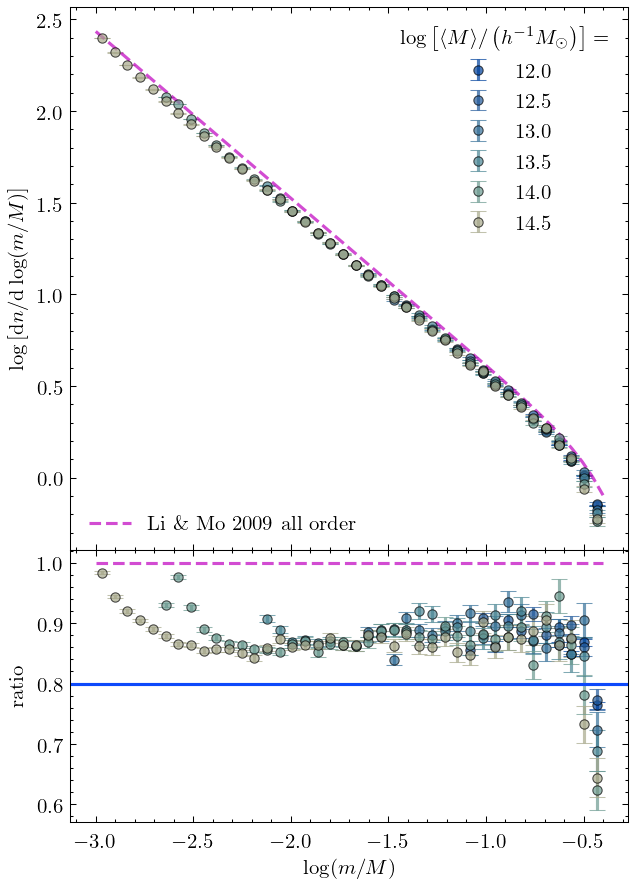

In [53]:
r = (-3,-0.4)
alpha=0.7
fig, (ax1,ax2) = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0, 'height_ratios': [2, 1]}, figsize=[4.8,4.8*1.5])

plotlist_fit = []
plotlist_residual = []
fitfn = 'LM09all'

labels = ['12.0', '12.5', '13.0', '13.5', '14.0', '14.5']
colors = ['#009292', '#b66dff', '#dbd100', '#009292', '#b66dff', '#dbd100']

colors= ['#00429d', '#235a9b', '#377199', '#4c8795', '#6c9b91', '#a7a88b']

# Marray [36,29,21,13,5,0]
for i, cuti in enumerate([36,29,21,13,5,0]):
    x = plotlist_all_small[i][0][cuti:]
    y = plotlist_all_small[i][1][cuti:]
    yerr = np.array(plotlist_all_small[i][2])[cuti:]
    yerr_log = np.array(plotlist_all_small[i][3])[:,cuti:]
#     print y
    finmask = np.isfinite(y)
    assert np.sum(finmask)==len(x)
    
    plotlist_fit.append((x,y))
    plotlist_residual.append( (x, 10**(y-unevolved_fitting_fns(fitfn=fitfn, log_m_over_M=x)[1]), yerr/10**unevolved_fitting_fns(fitfn=fitfn, log_m_over_M=x)[1]) )
    ax1.errorbar(x, y, yerr=yerr_log, label=labels[i], marker='o', ls='', mec='k', alpha=alpha, mew=0.5, ms=20**0.5, c=colors[i], capsize=4, elinewidth=1.5 )

ax1.legend(title=r'$\log \left[ \langle M \rangle / \left(h^{{-1}}M_\odot \right) \right]=$')

xfit, yfit = unevolved_fitting_fns(r=r, fitfn='fit')
# ax1.plot(xfit, yfit, label='fit', alpha=0.7)

xfit2, yfit2 = unevolved_fitting_fns(r=r, fitfn='JB13')
# ax1.plot(xfit2, yfit2, 'b--', label='Jiang\&Bosch14', alpha=0.7)

xfit3, yfit3 = unevolved_fitting_fns(r=r, fitfn='G08')
# ax1.plot(xfit3, yfit3, 'm--', label='Giocoli+08', alpha=0.7)

xfit4, yfit4 = unevolved_fitting_fns(r=r, fitfn='LM09')
# ax1.plot(xfit4, yfit4, 'y--', label='Li\&Mo09', alpha=0.7)

xfit5, yfit5 = unevolved_fitting_fns(r=r, fitfn='LM09all')
ax1.plot(xfit5, yfit5, 'm--', label='Li\&Mo09 all', alpha=0.7)

# ax1.xlabel(r'$\log(m/M)$')
ax1.set_ylabel(r'$\log \left[ \mathrm{d}n/\mathrm{d} \log(m/M) \right]$')
# ax1.set_title( r'Unevolved mass function of first order cores' + ', z=' + str(round(SHMLM.step2z[499],3)) );
# ax1.set_ylim(-.6)

_, yfid = unevolved_fitting_fns(r=r, fitfn=fitfn)

xfit, yfit = unevolved_fitting_fns(r=r, fitfn='fit')
# ax2.plot(xfit, yfit-yfid, label='fit', alpha=0.7)

xfit2, yfit2 = unevolved_fitting_fns(r=r, fitfn='JB13')
# ax2.plot(xfit2, yfit2-yfid, 'b--', label='Jiang \& van den Bosch 14', alpha=0.7)

xfit3, yfit3 = unevolved_fitting_fns(r=r, fitfn='G08')
# ax2.plot(xfit3, yfit3-yfid, 'm--', label='Giocoli+ 08', alpha=0.7)

xfit4, yfit4 = unevolved_fitting_fns(r=r, fitfn='LM09')
# ax2.plot(xfit4, yfit4-yfid, 'y--', label='Li \& Mo 09', alpha=0.7)

xfit5, yfit5 = unevolved_fitting_fns(r=r, fitfn='LM09all')
ax2.plot(xfit5, 10**(yfit5-yfid), 'm--', label='Li \& Mo 2009 all order', alpha=0.7)

ax2.legend(loc='upper left', bbox_to_anchor=(0., 1.2))

for i in range(6):
    x, y, yerr = plotlist_residual[i]
    ax2.errorbar(x, y, yerr=yerr, label=labels[i], marker='o', ls='', mec='k', alpha=alpha, mew=0.5, ms=20**0.5, c=colors[i], capsize=4, elinewidth=1.5 )

ax2.set_xlabel(r'$\log(m/M)$')
ax2.set_ylabel(r'ratio')
# plt.savefig('usmf_ALLorder_LJ_LM09fit_6bins_variableNhost.pdf')
plt.axhline(.8)

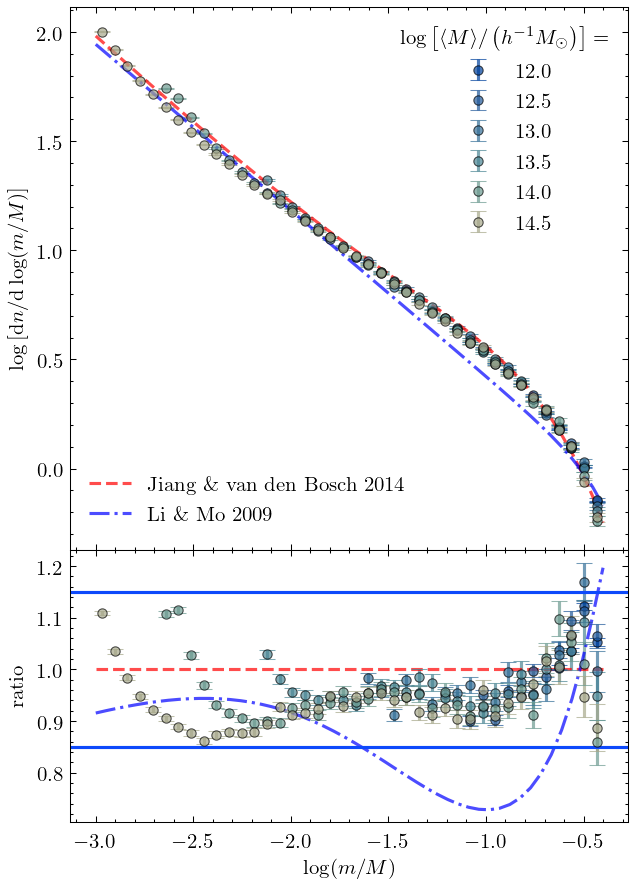

In [54]:
r = (-3,-0.4)
alpha=0.7
fig, (ax1,ax2) = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0, 'height_ratios': [2, 1]}, figsize=[4.8,4.8*1.5])

plotlist_fit = []
plotlist_residual = []
fitfn = 'JB13'

labels = ['12.0', '12.5', '13.0', '13.5', '14.0', '14.5']
colors = ['#009292', '#b66dff', '#dbd100', '#009292', '#b66dff', '#dbd100']

colors= ['#00429d', '#235a9b', '#377199', '#4c8795', '#6c9b91', '#a7a88b']

#Marray [36,29,21,13,5,0]
for i, cuti in enumerate([36,29,21,13,5,0]):
    x = plotlist[i][0][cuti:]
    y = plotlist[i][1][cuti:]
    yerr = np.array(plotlist[i][2])[cuti:]
    yerr_log = np.array(plotlist[i][3])[:,cuti:]
#     print y
    
    finmask = np.isfinite(y)
    assert np.sum(finmask)==len(x)
    
    plotlist_fit.append((x,y))
    plotlist_residual.append( (x, 10**(y-unevolved_fitting_fns(fitfn=fitfn, log_m_over_M=x)[1]), yerr/10**unevolved_fitting_fns(fitfn=fitfn, log_m_over_M=x)[1]) )
    
    ax1.errorbar(x, y, yerr=yerr_log, label=labels[i], marker='o', ls='', mec='k', alpha=alpha, mew=0.5, ms=20**0.5, c=colors[i], capsize=4, elinewidth=1.5 )

ax1.legend(title=r'$\log \left[ \langle M \rangle / \left(h^{{-1}}M_\odot \right) \right]=$')

xfit, yfit = unevolved_fitting_fns(r=r, fitfn='fit')
# ax1.plot(xfit, yfit, label='fit', alpha=0.7)

xfit2, yfit2 = unevolved_fitting_fns(r=r, fitfn='JB13')
ax1.plot(xfit2, yfit2, 'r--', label='Jiang\&Bosch14', alpha=0.7)

xfit3, yfit3 = unevolved_fitting_fns(r=r, fitfn='G08')
# ax1.plot(xfit3, yfit3, 'm--', label='Giocoli+08', alpha=0.7)

xfit4, yfit4 = unevolved_fitting_fns(r=r, fitfn='LM09')
ax1.plot(xfit4, yfit4, 'b-.', label='Li\&Mo09', alpha=0.7)

# ax1.xlabel(r'$\log(m/M)$')
ax1.set_ylabel(r'$\log \left[ \mathrm{d}n/\mathrm{d} \log(m/M) \right]$')
# ax1.set_title( r'Unevolved mass function of first order cores' + ', z=' + str(round(SHMLM.step2z[499],3)) );
# ax1.set_ylim(-.6)

_, yfid = unevolved_fitting_fns(r=r, fitfn=fitfn)

xfit, yfit = unevolved_fitting_fns(r=r, fitfn='fit')
# ax2.plot(xfit, yfit-yfid, label='fit', alpha=0.7)

xfit2, yfit2 = unevolved_fitting_fns(r=r, fitfn='JB13')
ax2.plot(xfit2, 10**(yfit2-yfid), 'r--', label='Jiang \& van den Bosch 2014', alpha=0.7)

xfit3, yfit3 = unevolved_fitting_fns(r=r, fitfn='G08')
# ax2.plot(xfit3, yfit3-yfid, 'm--', label='Giocoli+ 08', alpha=0.7)

xfit4, yfit4 = unevolved_fitting_fns(r=r, fitfn='LM09')
ax2.plot(xfit4, 10**(yfit4-yfid), 'b-.', label='Li \& Mo 2009', alpha=0.7)

ax2.legend(loc='upper left', bbox_to_anchor=(0., 1.35))

for i in range(6):
    x, y, yerr = plotlist_residual[i]
    ax2.errorbar(x, y, yerr=yerr, label=labels[i], marker='o', ls='', mec='k', alpha=alpha, mew=0.5, ms=20**0.5, c=colors[i], capsize=4, elinewidth=1.5 )

ax2.set_xlabel(r'$\log(m/M)$')
ax2.set_ylabel(r'ratio')
# plt.savefig('usmf_1order_LJ_JVBfit_LM09_6bins_variableNhost.pdf')
plt.axhline(1.15)
plt.axhline(.85)

# Old method

In [9]:
r = (-4,0.)
bins = 50
plotOptions = ''
alpha = 1

plotlist_all = []
plotlist_all.append( plotCMF('', M1=10**12, M2=10**13, s1=False, disrupt=None, returnUnevolved=True, label='[12.0, 13.0]', r=r, cc=cc_old_evolved, plotOptions=plotOptions, bins=bins, alpha=alpha, plotFlag=False, idx_m21=idx_m21) )
plotlist_all.append( plotCMF('', M1=10**13, M2=10**14, s1=False, disrupt=None, returnUnevolved=True, label='[13.0, 14.0]', r=r, cc=cc_old_evolved, plotOptions=plotOptions, bins=bins, alpha=alpha, plotFlag=False, idx_m21=idx_m21) )
plotlist_all.append( plotCMF('', M1=10**14, M2=10**15, s1=False, disrupt=None, returnUnevolved=True, label='[14.0, 15.0]', r=r, cc=cc_old_evolved, plotOptions=plotOptions, bins=bins, alpha=alpha, plotFlag=False, idx_m21=idx_m21) )
plotlist_all.append( plotCMF('', M1=10**15, M2=10**15.8, s1=False, disrupt=None, returnUnevolved=True, label='[15.0, 15.8]', r=r, cc=cc_old_evolved, plotOptions=plotOptions, bins=bins, alpha=alpha, plotFlag=False, idx_m21=idx_m21) )

plotlist_1 = []
plotlist_1.append( plotCMF('', M1=10**12, M2=10**13, s1=True, disrupt=None, returnUnevolved=True, label='[12.0, 13.0]1o', r=r, cc=cc_old_evolved, plotOptions=plotOptions, bins=bins, alpha=alpha, plotFlag=False, idx_m21=idx_m21) )
plotlist_1.append( plotCMF('', M1=10**13, M2=10**14, s1=True, disrupt=None, returnUnevolved=True, label='[13.0, 14.0]1o', r=r, cc=cc_old_evolved, plotOptions=plotOptions, bins=bins, alpha=alpha, plotFlag=False, idx_m21=idx_m21) )
plotlist_1.append( plotCMF('', M1=10**14, M2=10**15, s1=True, disrupt=None, returnUnevolved=True, label='[14.0, 15.0]1o', r=r, cc=cc_old_evolved, plotOptions=plotOptions, bins=bins, alpha=alpha, plotFlag=False, idx_m21=idx_m21) )
plotlist_1.append( plotCMF('', M1=10**15, M2=10**15.8, s1=True, disrupt=None, returnUnevolved=True, label='[15.0, 15.8]1o', r=r, cc=cc_old_evolved, plotOptions=plotOptions, bins=bins, alpha=alpha, plotFlag=False, idx_m21=idx_m21) )

139658585


/home/isultan/projects/itk/itk.py:84: RuntimeWarning: divide by zero encountered in log10
  cnts = np.log10(cnts)


15825664
997829
6126
139658585
15825664
997829
6126


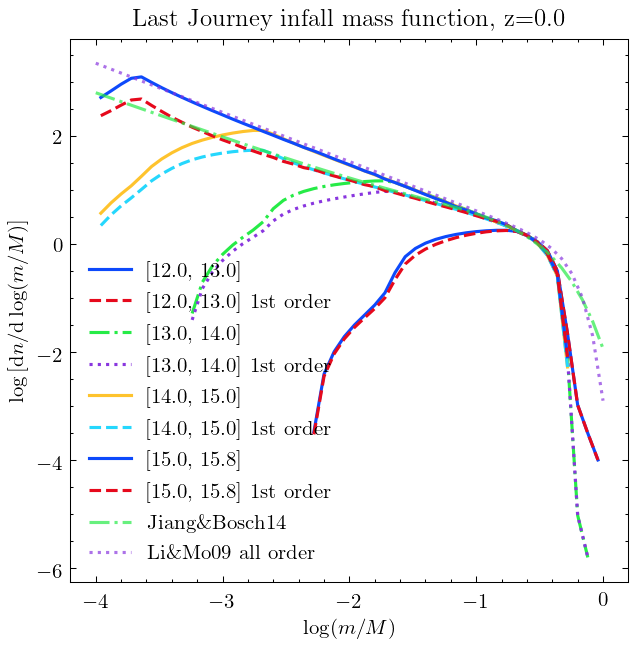

In [11]:
r = (-4,0.)
labels = ['[12.0, 13.0]', '[13.0, 14.0]', '[14.0, 15.0]', '[15.0, 15.8]']
colors = ['r', 'g', 'silver']

for i in range(4):
    x = plotlist_all[i][0]
    y = plotlist_all[i][1]
    plt.plot(x, y, label=labels[i])
    x = plotlist_1[i][0]
    y = plotlist_1[i][1]
    plt.plot(x, y, label=labels[i]+' 1st order')

for i in range(4):
    continue
    x = plotlist_1[i][0]
    y = plotlist_1[i][1]
    plt.plot(x, y, label=labels[i]+'1')

xfit, yfit = unevolved_fitting_fns(r=r, fitfn='fit')
# plt.plot(xfit, yfit, label='fit', alpha=0.7)

xfit2, yfit2 = unevolved_fitting_fns(r=r, fitfn='JB13')
plt.plot(xfit2, yfit2, label='Jiang\&Bosch14', alpha=0.7)

xfit3, yfit3 = unevolved_fitting_fns(r=r, fitfn='G08')
# plt.plot(xfit3, yfit3, label='Giocoli+08', alpha=0.7)

xfit4, yfit4 = unevolved_fitting_fns(r=r, fitfn='LM09')
# plt.plot(xfit4, yfit4, label='Li\&Mo09', alpha=0.7)

xfit5, yfit5 = unevolved_fitting_fns(r=r, fitfn='LM09all')
plt.plot(xfit5, yfit5, label='Li\&Mo09 all order', alpha=0.7)

plt.xlabel(r'$\log(m/M)$')
plt.ylabel(r'$\log \left[ \mathrm{d}n/\mathrm{d} \log(m/M) \right]$')
plt.title( r'Last Journey infall mass function' + ', z=' + str(round(SHMLM.step2z[499],3)) );
plt.legend()
# plt.ylim()
# plt.axvline(-0.4, c='k')

In [9]:
r = (-3,-0.4)
bins = 40
plotOptions = ''
alpha = 1

plotlist_all_small = []

plotlist_all_small.append( plotCMF('', M1=10**12, M2=10**13, s1=False, disrupt=None, returnUnevolved=True, label='[12.0, 13.0]', r=r, cc=cc_old_evolved, plotOptions=plotOptions, bins=bins, alpha=alpha, plotFlag=False, idx_m21=idx_m21, retEbars=True) )
plotlist_all_small.append( plotCMF('', M1=10**13, M2=10**14, s1=False, disrupt=None, returnUnevolved=True, label='[13.0, 14.0]', r=r, cc=cc_old_evolved, plotOptions=plotOptions, bins=bins, alpha=alpha, plotFlag=False, idx_m21=idx_m21, retEbars=True) )
plotlist_all_small.append( plotCMF('', M1=10**14, M2=10**15, s1=False, disrupt=None, returnUnevolved=True, label='[14.0, 15.0]', r=r, cc=cc_old_evolved, plotOptions=plotOptions, bins=bins, alpha=alpha, plotFlag=False, idx_m21=idx_m21, retEbars=True) )

139658585


/home/isultan/projects/itk/itk.py:92: RuntimeWarning: divide by zero encountered in log10
  cnts = np.log10(cnts)


15825664
997829


[ 0.18516103  0.10423369  0.00646342 -0.14307837]
[ 1.15686940e+00  1.10466785e+00  1.04723628e+00  9.89938192e-01
  9.33136177e-01  8.75770528e-01  8.17596511e-01  7.58833814e-01
  6.99712435e-01  6.39513977e-01  5.79448905e-01  5.18246111e-01
  4.56262122e-01  3.94185356e-01  3.30189642e-01  2.64064949e-01
  1.93302567e-01  1.10737585e-01 -6.52205271e-04 -1.91732959e-01]
[ 2.07730091  2.00624469  1.93832697  1.8722836   1.80891998  1.74728739
  1.68636937  1.62672925  1.56761645  1.50878229  1.45072702  1.3931224
  1.33473217  1.27644373  1.21957593  1.16190443  1.10432008  1.04570029
  0.98740733  0.92907926  0.86940798  0.80946273  0.75172832  0.6909999
  0.63172017  0.57119437  0.5107748   0.44893392  0.39061693  0.32816446
  0.26393501  0.18766123  0.09940617 -0.03658458 -0.2342709 ]


Text(0,0.5,'ratio')

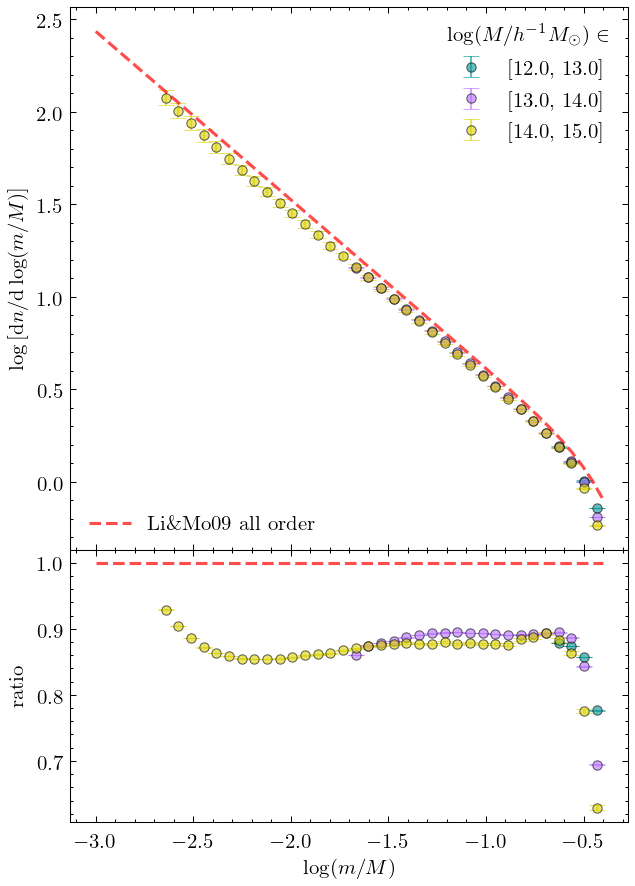

In [13]:
r = (-3,-0.4)
fig, (ax1,ax2) = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0, 'height_ratios': [2, 1]}, figsize=[4.8,4.8*1.5])

plotlist_fit = []
plotlist_residual = []
plotlist_residual_error = []
fitfn = 'LM09all'
# labels = ['[12.0, 12.5]', '[12.5, 13.0]', '[13.0, 13.5]', '[13.5, 14.0]', '[14.0, 14.5]']
labels = ['[12.0, 13.0]', '[13.0, 14.0]', '[14.0, 15.0]']
colors = ['#009292', '#b66dff', '#dbd100']

for i, cuti in enumerate([36,20,5]):
    x = plotlist_all_small[i][0][cuti:]
    y = plotlist_all_small[i][1][cuti:]
    yerr = np.array(plotlist_all_small[i][2])[cuti:]
    print y
    finmask = np.isfinite(y)
    assert np.sum(finmask)==len(x)
    x = x[finmask]
    y = y[finmask]
    
    plotlist_fit.append((x,y))
    plotlist_residual.append((x,10**(y-unevolved_fitting_fns(fitfn=fitfn, log_m_over_M=x)[1])))
    plotlist_residual_error.append(yerr/10**unevolved_fitting_fns(fitfn=fitfn, log_m_over_M=x)[1])
#     ax1.scatter(x, y, label=labels[i], edgecolors='k', alpha=0.6, linewidths=0.5, s=20, c=colors[i] )
    ax1.errorbar(x, y, yerr=yerr, label=labels[i], marker='o', ls='', mec='k', alpha=0.6, mew=0.5, ms=20**0.5, c=colors[i], capsize=4, elinewidth=1 )

ax1.legend(title='$\log(M/h^{{-1}}M_\odot)\in$')

xfit, yfit = unevolved_fitting_fns(r=r, fitfn='fit')
# ax1.plot(xfit, yfit, label='fit', alpha=0.7)

xfit2, yfit2 = unevolved_fitting_fns(r=r, fitfn='JB13')
# ax1.plot(xfit2, yfit2, 'b--', label='Jiang\&Bosch14', alpha=0.7)

xfit3, yfit3 = unevolved_fitting_fns(r=r, fitfn='G08')
# ax1.plot(xfit3, yfit3, 'm--', label='Giocoli+08', alpha=0.7)

xfit4, yfit4 = unevolved_fitting_fns(r=r, fitfn='LM09')
# ax1.plot(xfit4, yfit4, 'y--', label='Li\&Mo09', alpha=0.7)

xfit5, yfit5 = unevolved_fitting_fns(r=r, fitfn='LM09all')
ax1.plot(xfit5, yfit5, 'r--', label='Li\&Mo09 all', alpha=0.7)

# ax1.xlabel(r'$\log(m/M)$')
ax1.set_ylabel(r'$\log \left[ \mathrm{d}n/\mathrm{d} \log(m/M) \right]$')
# ax1.set_title( r'Unevolved mass function of first order cores' + ', z=' + str(round(SHMLM.step2z[499],3)) );
# ax1.set_ylim(-.6)

_, yfid = unevolved_fitting_fns(r=r, fitfn=fitfn)

xfit, yfit = unevolved_fitting_fns(r=r, fitfn='fit')
# ax2.plot(xfit, yfit-yfid, label='fit', alpha=0.7)

xfit2, yfit2 = unevolved_fitting_fns(r=r, fitfn='JB13')
# ax2.plot(xfit2, yfit2-yfid, 'b--', label='Jiang \& van den Bosch 14', alpha=0.7)

xfit3, yfit3 = unevolved_fitting_fns(r=r, fitfn='G08')
# ax2.plot(xfit3, yfit3-yfid, 'm--', label='Giocoli+ 08', alpha=0.7)

xfit4, yfit4 = unevolved_fitting_fns(r=r, fitfn='LM09')
# ax2.plot(xfit4, yfit4-yfid, 'y--', label='Li \& Mo 09', alpha=0.7)

xfit5, yfit5 = unevolved_fitting_fns(r=r, fitfn='LM09all')
ax2.plot(xfit5, 10**(yfit5-yfid), 'r--', label='Li\&Mo09 all order', alpha=0.7)

ax2.legend(loc='upper left', bbox_to_anchor=(0., 1.2))

for i in range(3):
    x = plotlist_residual[i][0]
    y = plotlist_residual[i][1]
#     ax2.scatter(x, y, label=labels[i], edgecolors='k', alpha=0.6, linewidths=0.5, s=20, c=colors[i] )
    ax2.errorbar(x, y, yerr=plotlist_residual_error[i], label=labels[i], marker='o', ls='', mec='k', alpha=0.6, mew=0.5, ms=20**0.5, c=colors[i], capsize=4, elinewidth=1 )


ax2.set_xlabel(r'$\log(m/M)$')
ax2.set_ylabel(r'ratio')
# plt.savefig('usmf_ALLorder_LJ_LM09fit.pdf')

In [15]:
r = (-3,-0.4)
bins = 40
plotOptions = ''
alpha = 1

plotlist = []
# plotlist.append( plotCMF('', M1=10**12, M2=10**12.5, s1=True, disrupt=None, returnUnevolved=True, label='[12.0, 12.5]', r=r, cc=cc_old_evolved, plotOptions=plotOptions, bins=bins, alpha=alpha, plotFlag=False) )
# plotlist.append( plotCMF('', M1=10**12.5, M2=10**13, s1=True, disrupt=None, returnUnevolved=True, label='[12.5, 13.0]', r=r, cc=cc_old_evolved, plotOptions=plotOptions, bins=bins, alpha=alpha, plotFlag=False) )
# plotlist.append( plotCMF('', M1=10**13, M2=10**13.5, s1=True, disrupt=None, returnUnevolved=True, label='[13.0, 13.5]', r=r, cc=cc_old_evolved, plotOptions=plotOptions, bins=bins, alpha=alpha, plotFlag=False) )
# plotlist.append( plotCMF('', M1=10**13.5, M2=10**14, s1=True, disrupt=None, returnUnevolved=True, label='[13.5, 14.0]', r=r, cc=cc_old_evolved, plotOptions=plotOptions, bins=bins, alpha=alpha, plotFlag=False) )
# plotlist.append( plotCMF('', M1=10**14, M2=10**14.5, s1=True, disrupt=None, returnUnevolved=True, label='[14.0, 14.5]', r=r, cc=cc_old_evolved, plotOptions=plotOptions, bins=bins, alpha=alpha, plotFlag=False) )

plotlist.append( plotCMF('', M1=10**12, M2=10**13, s1=True, disrupt=None, returnUnevolved=True, label='[12.0, 13.0]', r=r, cc=cc_old_evolved, plotOptions=plotOptions, bins=bins, alpha=alpha, plotFlag=False, idx_m21=idx_m21) )
plotlist.append( plotCMF('', M1=10**13, M2=10**14, s1=True, disrupt=None, returnUnevolved=True, label='[13.0, 14.0]', r=r, cc=cc_old_evolved, plotOptions=plotOptions, bins=bins, alpha=alpha, plotFlag=False, idx_m21=idx_m21) )
plotlist.append( plotCMF('', M1=10**14, M2=10**15, s1=True, disrupt=None, returnUnevolved=True, label='[14.0, 15.0]', r=r, cc=cc_old_evolved, plotOptions=plotOptions, bins=bins, alpha=alpha, plotFlag=False, idx_m21=idx_m21) )

139658585
15825664
997829


Text(0,0.5,'ratio')

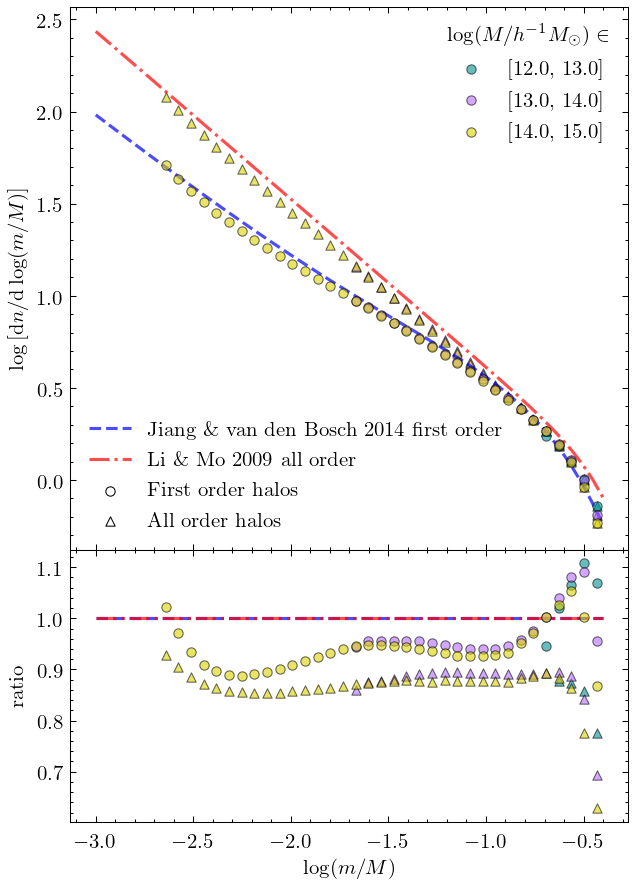

In [46]:
r = (-3,-0.4)
fig, (ax1,ax2) = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0, 'height_ratios': [2, 1]}, figsize=[4.8,4.8*1.5])

plotlist_fit = []
plotlist_residual = []
fitfn = 'JB13'
# labels = ['[12.0, 12.5]', '[12.5, 13.0]', '[13.0, 13.5]', '[13.5, 14.0]', '[14.0, 14.5]']
labels = ['[12.0, 13.0]', '[13.0, 14.0]', '[14.0, 15.0]']
colors = ['#009292', '#b66dff', '#dbd100']

for i, cuti in enumerate([35,20,5]):
    x = plotlist[i][0][cuti:]
    y = plotlist[i][1][cuti:]
    finmask = np.isfinite(y)
    x = x[finmask]
    y = y[finmask]
    
    plotlist_fit.append((x,y))
    plotlist_residual.append((x,10**(y-unevolved_fitting_fns(fitfn=fitfn, log_m_over_M=x)[1])))
    ax1.scatter(x, y, label=labels[i], edgecolors='k', alpha=0.6, linewidths=0.5, s=20, c=colors[i], zorder=5 )

ax1.legend(title='$\log(M/h^{{-1}}M_\odot)\in$')


plotlist_fit_all_small = []
plotlist_residual_all_small = []
fitfn_all_small = 'LM09all'
for i, cuti in enumerate([36,20,5]):
    x = plotlist_all_small[i][0][cuti:]
    y = plotlist_all_small[i][1][cuti:]
    finmask = np.isfinite(y)
    x = x[finmask]
    y = y[finmask]
    
    plotlist_fit_all_small.append((x,y))
    plotlist_residual_all_small.append((x,10**(y-unevolved_fitting_fns(fitfn=fitfn_all_small, log_m_over_M=x)[1])))
    ax1.scatter(x, y, label=labels[i], edgecolors='k', alpha=0.6, linewidths=0.5, s=20, c=colors[i], marker='^' )

xfit2, yfit2 = unevolved_fitting_fns(r=r, fitfn='JB13')
ax1.plot(xfit2, yfit2, 'b--', label='Jiang\&Bosch14', alpha=0.7)

xfit5, yfit5 = unevolved_fitting_fns(r=r, fitfn='LM09all')
ax1.plot(xfit5, yfit5, 'r-.', label='Li\&Mo09 all', alpha=0.7)

# ax1.xlabel(r'$\log(m/M)$')
ax1.set_ylabel(r'$\log \left[ \mathrm{d}n/\mathrm{d} \log(m/M) \right]$')
# ax1.set_title( r'Unevolved mass function of first order cores' + ', z=' + str(round(SHMLM.step2z[499],3)) );
# ax1.set_ylim(-.6)

ax2.scatter([], [], label='First order halos', edgecolors='k', linewidths=0.5, s=20, c='w' )
ax2.scatter([], [], label='All order halos', edgecolors='k', linewidths=0.5, s=20, c='w', marker='^' )

_, yfid = unevolved_fitting_fns(r=r, fitfn=fitfn)

xfit2, yfit2 = unevolved_fitting_fns(r=r, fitfn='JB13')
ax2.plot(xfit2, 10**(yfit2-yfid), 'b--', label='Jiang \& van den Bosch 2014 first order', alpha=0.7)
    
##
_, yfid_all_small = unevolved_fitting_fns(r=r, fitfn=fitfn_all_small)
xfit5, yfit5 = unevolved_fitting_fns(r=r, fitfn='LM09all')
ax2.plot(xfit5, 10**(yfit5-yfid_all_small), 'r-.', label='Li \& Mo 2009 all order', alpha=0.7)

ax2.legend(loc='upper left', bbox_to_anchor=(0., 1.55))

for i in range(3):
    x = plotlist_residual[i][0]
    y = plotlist_residual[i][1]
    ax2.scatter(x, y, label=labels[i], edgecolors='k', alpha=0.6, linewidths=0.5, s=20, c=colors[i], zorder=5 )

for i in range(3):
#     continue
    x = plotlist_residual_all_small[i][0]
    y = plotlist_residual_all_small[i][1]
    ax2.scatter(x, y, label=labels[i], edgecolors='k', alpha=0.6, linewidths=0.5, s=20, c=colors[i], marker='^' )
##

ax2.set_xlabel(r'$\log(m/M)$')
ax2.set_ylabel(r'ratio')
# plt.savefig('usmf_res_LJ_JVBfit.pdf')

Text(0,0.5,'ratio')

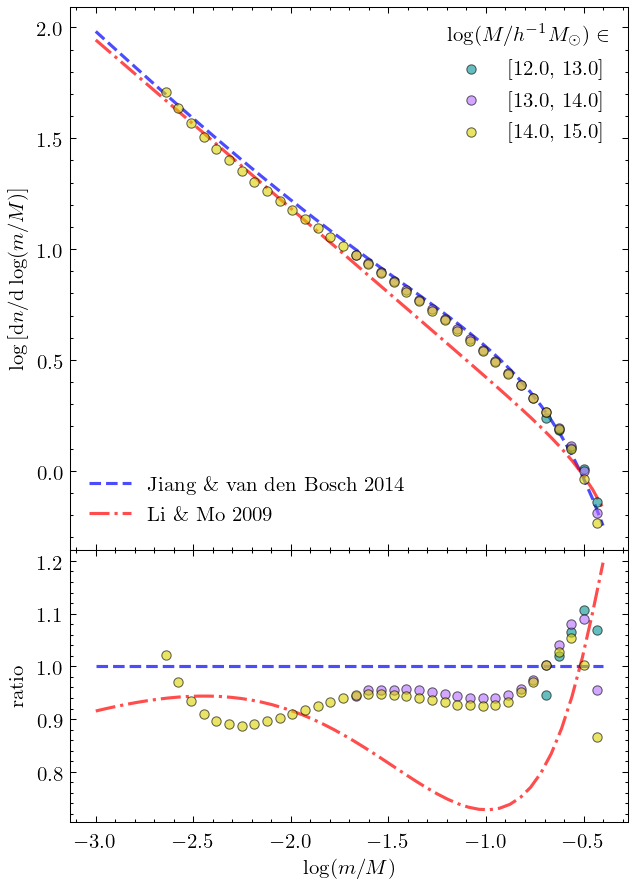

In [56]:
r = (-3,-0.4)
fig, (ax1,ax2) = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0, 'height_ratios': [2, 1]}, figsize=[4.8,4.8*1.5])

plotlist_fit = []
plotlist_residual = []
fitfn = 'JB13'
# labels = ['[12.0, 12.5]', '[12.5, 13.0]', '[13.0, 13.5]', '[13.5, 14.0]', '[14.0, 14.5]']
labels = ['[12.0, 13.0]', '[13.0, 14.0]', '[14.0, 15.0]']
colors = ['#009292', '#b66dff', '#dbd100']

for i, cuti in enumerate([35,20,5]):
    x = plotlist[i][0][cuti:]
    y = plotlist[i][1][cuti:]
    finmask = np.isfinite(y)
    assert np.sum(finmask)==len(x)
    x = x[finmask]
    y = y[finmask]
    
    plotlist_fit.append((x,y))
    plotlist_residual.append((x,10**(y-unevolved_fitting_fns(fitfn=fitfn, log_m_over_M=x)[1])))
    ax1.scatter(x, y, label=labels[i], edgecolors='k', alpha=0.6, linewidths=0.5, s=20, c=colors[i], zorder=5 )

ax1.legend(title='$\log(M/h^{{-1}}M_\odot)\in$')

xfit, yfit = unevolved_fitting_fns(r=r, fitfn='fit')
# ax1.plot(xfit, yfit, label='fit', alpha=0.7)

xfit2, yfit2 = unevolved_fitting_fns(r=r, fitfn='JB13')
ax1.plot(xfit2, yfit2, 'b--', label='Jiang\&Bosch14', alpha=0.7)

xfit3, yfit3 = unevolved_fitting_fns(r=r, fitfn='G08')
# ax1.plot(xfit3, yfit3, 'm--', label='Giocoli+08', alpha=0.7)

xfit4, yfit4 = unevolved_fitting_fns(r=r, fitfn='LM09')
ax1.plot(xfit4, yfit4, 'r-.', label='Li\&Mo09', alpha=0.7)

# ax1.xlabel(r'$\log(m/M)$')
ax1.set_ylabel(r'$\log \left[ \mathrm{d}n/\mathrm{d} \log(m/M) \right]$')
# ax1.set_title( r'Unevolved mass function of first order cores' + ', z=' + str(round(SHMLM.step2z[499],3)) );
# ax1.set_ylim(-.6)

_, yfid = unevolved_fitting_fns(r=r, fitfn=fitfn)

xfit, yfit = unevolved_fitting_fns(r=r, fitfn='fit')
# ax2.plot(xfit, yfit-yfid, label='fit', alpha=0.7)

xfit2, yfit2 = unevolved_fitting_fns(r=r, fitfn='JB13')
ax2.plot(xfit2, 10**(yfit2-yfid), 'b--', label='Jiang \& van den Bosch 2014', alpha=0.7)

xfit3, yfit3 = unevolved_fitting_fns(r=r, fitfn='G08')
# ax2.plot(xfit3, yfit3-yfid, 'm--', label='Giocoli+ 08', alpha=0.7)

xfit4, yfit4 = unevolved_fitting_fns(r=r, fitfn='LM09')
ax2.plot(xfit4, 10**(yfit4-yfid), 'r-.', label='Li \& Mo 2009', alpha=0.7)

ax2.legend(loc='upper left', bbox_to_anchor=(0., 1.35))

for i in range(3):
    x = plotlist_residual[i][0]
    y = plotlist_residual[i][1]
    ax2.scatter(x, y, label=labels[i], edgecolors='k', alpha=0.6, linewidths=0.5, s=20, c=colors[i], zorder=5 )

ax2.set_xlabel(r'$\log(m/M)$')
ax2.set_ylabel(r'ratio')
# plt.savefig('usmf_1order_LJ_JVBfit_LM09.pdf')

In [247]:
xarr, yarr = np.array([]), np.array([])
for x,y in plotlist_fit:
    xarr = np.r_[xarr, x]
    yarr = np.r_[yarr, y]

In [254]:
from scipy.optimize import curve_fit
curve_fit(unevolved_fitting_model, xarr, yarr, p0=(0.13, -0.83, 1.33, -0.02, 5.67, 1.19))

/home/isultan/.local/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


(array([ 1.10019253e-06, -2.37629301e+00,  3.13151000e-01, -6.62286828e-01,
         1.62963600e+01,  3.03449498e+00]),
 array([[ 8.75673058e-11,  1.20526374e-05,  1.43851458e-07,
          1.62337036e-07, -2.69032604e-05, -1.98899256e-06],
        [ 1.20526374e-05,  1.66132998e+00,  1.93959711e-02,
          2.19469277e-02, -3.60795343e+00, -2.66965626e-01],
        [ 1.43851458e-07,  1.93959711e-02,  4.27794052e-04,
          4.26371440e-04, -1.00629614e-01, -7.19576738e-03],
        [ 1.62337036e-07,  2.19469277e-02,  4.26371440e-04,
          4.42544842e-04, -9.35879815e-02, -6.75614607e-03],
        [-2.69032604e-05, -3.60795343e+00, -1.00629614e-01,
         -9.35879815e-02,  4.76538631e+01,  3.02496065e+00],
        [-1.98899256e-06, -2.66965626e-01, -7.19576738e-03,
         -6.75614607e-03,  3.02496065e+00,  1.96523287e-01]]))